Import files, etc. evt use terminal and pip 'install -r requirements.txt'.

In [ ]:
!pip install pandas numpy pyreadstat matplotlib openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.1/620.1 kB 12.8 MB/s eta 0:00:00


In [ ]:
import os, time, json, uuid, math, random, tempfile
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import openai
import pyreadstat
from typing import Dict, Any
from IPython.display import display
from google.colab import data_table
data_table.enable_dataframe_formatter()

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import textwrap

APIKEY = 

print("openai version:", openai.__version__)


openai version: 1.99.1


In [ ]:
# Configuration – tweak as needed
DATA_PATH = Path("TryghedsData.dta")
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

DEV_SAMPLE_SIZE = 1000
TRAIN_FRAC       = 0.7    # train / test split
RANDOM_SEED      = 42     # 42 for at genstkabe studie.
MODEL_NAME       = "gpt-3.5-turbo"   # GPT-3.5-Turbo / GPT-4.1 / o3
TEMPERATURE      = 1      # 1 / 2
MAX_TOKENS       = 2000
BATCH_DESC       = "corruption‑simulation‑dev"

Load Tryghedsmålingen

In [ ]:
df, meta = pyreadstat.read_dta(str(DATA_PATH))
print("Dimensions:", df.shape) # Burde være omkring 5725 x 309
display(df.columns.to_list()[:10], df.head(3))

Dimensions: (5725, 309)


['caseid', 'unique_key', 'SID', 'q3', 'q5', 'Q7', 'q7a', 'q29', 'q9B', 'Q9C_1']

,caseid,unique_key,SID,q3,q5,Q7,q7a,q29,q9B,Q9C_1,...,child_age_1,child_age_2,child_age_3,personal_income,FT_next,FT22,profile_house_tenure,house_type,device_category,weight
0,5.821822e+09,62118404.0,2.0,9.0,6.0,11.0,NaN,2.0,2.0,6.0,...,NaN,NaN,NaN,1.0,1.0,1.0,1.0,4.0,1.0,0.833614
1,5.821852e+09,12863762.0,2.0,3.0,9.0,6.0,3.0,1.0,1.0,6.0,...,NaN,NaN,NaN,5.0,21.0,21.0,1.0,4.0,1.0,0.561505
2,5.821982e+09,24153517.0,2.0,1.0,9.0,8.0,NaN,1.0,3.0,6.0,...,NaN,NaN,NaN,12.0,15.0,8.0,1.0,4.0,1.0,0.667901


Code Cleaning. Mostly renaming/mapping variables

In [ ]:
# Renaming the basic demographic columns
df = df.rename(columns={
    "alder":                  "age",
    "gender":                 "gender_raw",
    "profile_education":      "education_raw",
    "profile_marital":        "marital_raw",
    "family_status":          "family_raw",
    "children_in_household":  "children_raw",
    "personal_income":        "income_raw",
    "FT_next":                "party_raw",
    "FT22":                   "party_raw_2022",
    "q3":                     "city_size_raw",
    "kommune_ask":            "muni_raw"
})

# Identifing all 12 (9) Q81_4 grid columns and give them friendly names
grid_raw = [f"Q81_4_{i}" for i in [1,2,4,5,6,9,10,11,12]]
grid_friendly = [
    "hemmelighed",    # 1
    "ansvar_børn",    # 2
    "ærlighed",      # 4
    "løfte" ,         # 5
    "betaling",       # 6
    "hjælpsomhed",     # 9
    "korruption",      # 10
    "nød_vold",        # 11
    "ansvar_voksne"    # 12
]
rename_map = dict(zip(grid_raw, grid_friendly))
df = df.rename(columns=rename_map)

# Pulling in the value-labels for this grid (all Q81_4_* share one label set)
scale_map = meta.value_labels.get("Q81_4", {
    1: "Helt enig",
    2: "Delvist enig",
    3: "Hverken enig eller uenig",
    4: "Delvist uenig",
    5: "Helt uenig",
    6: "Ved ikke/Ikke relevant/Ønsker ikke at svare"
})

for item in grid_friendly:
    raw_col   = item + "_raw"
    label_col = item + "_label"
    ord_col   = item + "_ord"
    th_col    = item + "_therm"

    # copy the raw codes
    df[raw_col] = df[item]

    # map to label text
    df[label_col] = df[raw_col].map(scale_map)

    # recode 1–5 to ordinal and 6→NaN
    df[ord_col] = df[raw_col].replace({6: np.nan})

# Mapping demographics with their value-labels
gender_map    = meta.value_labels.get("gender", {})
education_map = meta.value_labels.get("profile_education", {})
marital_map   = meta.value_labels.get("profile_marital", {})
family_map    = meta.value_labels.get("family_status", {})
children_map  = meta.value_labels.get("children_in_household", {})
income_map    = meta.value_labels.get("personal_income", {})
party_map     = meta.value_labels.get("FT_next", {})
party22_map   = meta.value_labels.get("FT22", {})
city_map      = meta.value_labels.get("q3", {})
muni_map      = meta.value_labels.get("kommune_ask", {})

df["gender"]          = df["gender_raw"].replace(gender_map)
df["education"]       = df["education_raw"].replace(education_map)
df["marital"]         = df["marital_raw"].replace(marital_map)
df["family"]          = df["family_raw"].replace(family_map)
df["children"]        = df["children_raw"].replace(children_map)
df["income"]          = df["income_raw"].replace(income_map)
df["party_id"]        = df["party_raw"].replace(party_map)
df["party_id_2022"]   = df["party_raw_2022"].replace(party22_map)
df["city_size"]       = df["city_size_raw"].replace(city_map)
df["municipality"]    = df["muni_raw"].replace(muni_map)

print("After full Q81_4 cleanup:", df.shape)
display(df[ ["age","gender","education","marital","family","children","income","party_id","party_id_2022","city_size","municipality"] + [item +"_label" for item in grid_friendly] ].head())

After full Q81_4 cleanup: (5725, 346)


,age,gender,education,marital,family,children,income,party_id,party_id_2022,city_size,municipality,hemmelighed_label,ansvar_børn_label,ærlighed_label,løfte_label,betaling_label,hjælpsomhed_label,korruption_label,nød_vold_label,ansvar_voksne_label
0,26.0,Kvinde,Almen gymnasial uddannelse (studentereksamen/HF),"Samlevende, men ikke gift eller i registreret ...",Jeg bor hjemme hos mine forældre (eller én af ...,0,Mindre end 100.000 kr.,A. Socialdemokratiet,A. Socialdemokratiet,Ved ikke/ønsker ikke at svare,Herning,Ved ikke/Ikke relevant/Ønsker ikke at svare,Ved ikke/Ikke relevant/Ønsker ikke at svare,Ved ikke/Ikke relevant/Ønsker ikke at svare,Ved ikke/Ikke relevant/Ønsker ikke at svare,Ved ikke/Ikke relevant/Ønsker ikke at svare,Ved ikke/Ikke relevant/Ønsker ikke at svare,Ved ikke/Ikke relevant/Ønsker ikke at svare,Ved ikke/Ikke relevant/Ønsker ikke at svare,Ved ikke/Ikke relevant/Ønsker ikke at svare
1,67.0,Kvinde,Lang videregående uddannelse 5 år eller mere,Fraskilt,Jeg er single/enlig/ikke samboende og har inge...,0,400.000 til 499.999 kr.,M. Moderaterne,M. Moderaterne,En by med over 40.000 indbyggere,Viborg,Hverken enig eller uenig,Helt uenig,Hverken enig eller uenig,Delvist enig,Hverken enig eller uenig,Hverken enig eller uenig,Hverken enig eller uenig,Hverken enig eller uenig,Helt enig
2,75.0,Kvinde,Kort videregående uddannelse under 3 år,Gift,Jeg er samboende/gift/registreret partnerskab ...,0,Ønsker ikke at oplyse,Ved ikke,"V. Venstre, Danmarks Liberale Parti",København / Storkøbenhavn,Hørsholm,Hverken enig eller uenig,Delvist uenig,Hverken enig eller uenig,Hverken enig eller uenig,Delvist enig,Delvist enig,Ved ikke/Ikke relevant/Ønsker ikke at svare,Hverken enig eller uenig,Helt enig
3,73.0,Mand,Lang videregående uddannelse 5 år eller mere,Gift,Jeg er samboende/gift/registreret partnerskab ...,0,600.000 til 699.999 kr.,"V. Venstre, Danmarks Liberale Parti","V. Venstre, Danmarks Liberale Parti",København / Storkøbenhavn,Greve,Helt enig,Hverken enig eller uenig,Delvist enig,Delvist uenig,Hverken enig eller uenig,Delvist enig,Delvist enig,Helt uenig,Delvist enig
4,76.0,Mand,Erhvervsfaglig uddannelse,Gift,Jeg er samboende/gift/registreret partnerskab ...,0,Ønsker ikke at oplyse,Ved ikke,"V. Venstre, Danmarks Liberale Parti",København / Storkøbenhavn,Hvidovre,Delvist enig,Delvist enig,Delvist uenig,Delvist enig,Ved ikke/Ikke relevant/Ønsker ikke at svare,Delvist enig,Delvist enig,Delvist enig,Hverken enig eller uenig


Train/Dev/Test split, fordelt på hvilket parti folk vil stemme på. Sample size trækkes ud fra train.

In [ ]:
rng = np.random.RandomState(RANDOM_SEED)

# Stratify by party_id
if "party_id" in df:
    train_idx = (
        df.groupby("party_id", group_keys=False)
          .apply(lambda g: g.sample(frac=TRAIN_FRAC, random_state=rng))
          .index
    )
else:
    train_idx = df.sample(frac=TRAIN_FRAC, random_state=rng).index

train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.drop(train_idx).reset_index(drop=True)

dev_df = train_df.sample(
    n=min(DEV_SAMPLE_SIZE, len(train_df)),
    random_state=rng
).reset_index(drop=True)

print(f"Train: {len(train_df):,} | Dev: {len(dev_df):,} | Test: {len(test_df):,}")

Train: 4,007 | Dev: 1,000 | Test: 1,718


/tmp/ipython-input-393328097.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=TRAIN_FRAC, random_state=rng))


prompt building.

In [ ]:
SYSTEM_PROMPT = (
    "Du er deltager i en opinionsundersøgelse (Tryghedsmålingen 2024). Dette er en dansk undersøgelse, fortaget i 2024, som undersøger danske borgers tryghed."
    "Du skal simulere respondenten nedenfor i forbindelse med forskning."
)

def build_user_prompt(row: pd.Series) -> str:
    persona = (
        f"Du er en {row.age}-årig {row.gender} med {row.education}, "
        f"{row.marital}, {row.family}, har {row.children} børn i hjemmet, "
        f"en personlig indkomst på {row.income} kr., "
        f"du stemte på {row.party_id_2022} ved sidste valg, og planlægger at stemme på {row.party_id}. "
        f"Du bor i en {row.city_size} størrelse by i {row.municipality}."
    )
    question_intro = (
        "Hvor enig eller uenig er du i følgende udsagn?"
        "Svar for hvert udsagn med en af følgende fem svarmuligheder:"
        "Helt enig\n"
        "Delvist enig\n"
        "Hverken enig eller uenig\n"
        "Delvist uenig\n"
        "Helt uenig\n"
    )

    udsagn = [
        "Det er de færreste, der kan holde på en vigtig hemmelighed",
        "Folk tager typisk ansvaret, hvis deres børn har gjort noget galt",
        "De fleste er normalt ærlige, når de fortæller om noget, de har oplevet",
        "Det er efterhånden de færreste, der sætter en ære i at holde, hvad de lover",
        "Det er meget få, der ikke betaler, når de tager noget fra en bod ved vejen",
        "De fleste vil gerne hjælpe andre, også selvom de ikke kender dem",
        "Korruption er meget sjældent i Danmark",
        "Næsten ingen bruger vold, bortset fra i nødstilfælde",
        "Man kan stole på at de allerfleste voksne vil opføre sig ansvarligt/ordentligt, "
        "hvis de har ansvaret for andres børn"
    ]
    # nummerer udsagnene
    udsagnstekst = "\n".join(f"{i+1}. {t}" for i, t in enumerate(udsagn))

    instruction = (
        "Giv dit svar i JSON-format nøjagtigt som nedenfor, "
        "med nøglerne i denne rækkefølge:\n"
        '{"hemmelighed": "<kategori>", '
        '"ansvar_børn": "<kategori>", '
        '"ærlighed": "<kategori>", '
        '"løfte": "<kategori>", '
        '"betaling": "<kategori>", '
        '"hjælpsomhed": "<kategori>", '
        '"korruption": "<kategori>", '
        '"nød_vold": "<kategori>", '
        '"ansvar_voksne": "<kategori>"}\n\n'
        "Hvor <kategori> er et af: "
        "'Helt enig', 'Delvist enig', 'Hverken enig eller uenig', "
        "'Delvist uenig', 'Helt uenig'."
    )

    return "\n\n".join([persona, question_intro, udsagnstekst, instruction])

# Sanity check på dev-sæt
print(build_user_prompt(dev_df.iloc[0]))

Du er en 52.0-årig Kvinde med Erhvervsgymnasial uddannelse (HH/HTX/HHX), Fraskilt, Jeg er single/enlig/ikke samboende og har ingen hjemmeboende børn, har 0 børn i hjemmet, en personlig indkomst på 100.000 til 199.999 kr. kr., du stemte på Stemte ikke/stemte blankt ved sidste valg, og planlægger at stemme på Vil ikke stemme. Du bor i en På landet størrelse by i Bornholm.

Hvor enig eller uenig er du i følgende udsagn?Svar for hvert udsagn med en af følgende fem svarmuligheder:Helt enig
Delvist enig
Hverken enig eller uenig
Delvist uenig
Helt uenig


1. Det er de færreste, der kan holde på en vigtig hemmelighed
2. Folk tager typisk ansvaret, hvis deres børn har gjort noget galt
3. De fleste er normalt ærlige, når de fortæller om noget, de har oplevet
4. Det er efterhånden de færreste, der sætter en ære i at holde, hvad de lover
5. Det er meget få, der ikke betaler, når de tager noget fra en bod ved vejen
6. De fleste vil gerne hjælpe andre, også selvom de ikke kender dem
7. Korruption er

Creating Json file as prep for batch

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

jsonl_path = OUTPUT_DIR / f"batch_dev_{timestamp}_{uuid.uuid4()}.jsonl"
with open(jsonl_path, "w", encoding="utf-8") as fout:
    for idx, row in dev_df.iterrows():
        payload = {
            "custom_id": str(idx),
            "method":    "POST",
            "url":       "/v1/responses",
            "body": {
                "model": MODEL_NAME,
                "instructions": SYSTEM_PROMPT,
                "input": build_user_prompt(row),
                "temperature": TEMPERATURE
            }
        }
        fout.write(json.dumps(payload) + "\n")

print("Wrote JSONL →", jsonl_path)

Wrote JSONL → outputs/batch_dev_20250810_145054_b4ef8c53-60ef-4e43-9b3b-c502119fc255.jsonl


Uploading file to OpenAI

In [ ]:
client = openai.OpenAI(api_key=APIKEY)

upload_response = client.files.create(
  file=open(jsonl_path,"rb"),
  purpose="batch"
)

file_id = upload_response.id

Create Batch from uploaded file.

In [ ]:
create_batch = True # True / False

if create_batch:
    batch = client.batches.create(
        input_file_id=file_id,
        endpoint="/v1/responses",
        completion_window="24h"
    )
    batch_id = batch.id
    with open(OUTPUT_DIR / "latest_batch_id.txt", "w") as f:
        f.write(batch_id)
    print("Submitted batch with ID:", batch_id)
else:
    cache_path = OUTPUT_DIR / "latest_batch_id.txt"
    if cache_path.exists():
        batch_id = cache_path.read_text().strip()
        print("Reusing cached batch_id:", batch_id)
    else:
        result_files = sorted(
            OUTPUT_DIR.glob("results_*.jsonl"),
            key=lambda p: p.stat().st_mtime,
            reverse=True
        )
        if not result_files:
            raise FileNotFoundError("No previous results found; cannot infer batch_id")

        batch_id = result_files[0].stem.removeprefix("results_")
        print("Inferred batch_id from latest results file:", batch_id)

Submitted batch with ID: batch_6898b1d533e48190bdf3fe286e1b35ae


Check status of batch, and if done, download it.

In [ ]:
poll     = True

if poll:
    status = client.batches.retrieve(batch_id)
    print("Status:", status.status)
    if status.status == "completed":
        out_id = status.output_file_id
        result_path = OUTPUT_DIR / f"results_{batch_id}.jsonl"
        resp = client.files.content(out_id)
        result_path.write_bytes(resp.read())
        print("Saved results to", result_path)
else:
    print("Polling disabled until 'poll=True'.")

Status: completed
Saved results to outputs/results_batch_6898b1d533e48190bdf3fe286e1b35ae.jsonl


check results/LLM-predictions.

In [ ]:
fallback_name = "Strong-T.jsonl"

try:
    RESULTS_JSONL = os.path.join(OUTPUT_DIR, f"results_{batch_id}.jsonl")

    if not os.path.isfile(RESULTS_JSONL):
        RESULTS_JSONL = os.path.join(OUTPUT_DIR, fallback_name)

except NameError:
    RESULTS_JSONL = os.path.join(OUTPUT_DIR, fallback_name)

category_map = {
    "helt enig": 1,
    "delvist enig": 2,
    "hverken enig eller uenig": 3,
    "delvist uenig": 4,
    "helt uenig": 5,
}

pred_rows = []
with open(RESULTS_JSONL, encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)

        # 1 find the message part
        body = obj["response"].get("body", obj["response"])
        msg = next(
            (item for item in body["output"]
             if item.get("type") == "message" and "content" in item),
            None,
        )
        if msg is None:
            print("Skip line (no message/content)")
            continue

        try:
            row_id   = int(obj["custom_id"])
            txt      = msg["content"][0]["text"]
            pred_dict = json.loads(txt)
        except Exception as e:
            print("Skip line (parse error):", e)
            continue

        # 2 clean and collect
        clean = {}
        for k, v in pred_dict.items():
            # normalize to lowercase, strip whitespace, quotes, trailing dots
            norm = v.strip().strip('"').rstrip('.').lower()
            clean[k] = category_map.get(norm, np.nan)
            if np.isnan(clean[k]):
                print(f"Unrecognized category for {k!r}: {v!r} → normalized {norm!r}")

        pred_rows.append({"dev_idx": row_id, **clean})

# 3 build DataFrame
if not pred_rows:
    raise ValueError("No valid rows were parsed from the JSONL file.")

pred_df = pd.DataFrame(pred_rows).set_index("dev_idx")
print("Parsed predictions:", pred_df.shape)
display(pred_df.head())

Skip line (parse error): Expecting value: line 1 column 1 (char 0)
Unrecognized category for 'hjælpsomhed': 'Hvert enig' → normalized 'hvert enig'
Unrecognized category for 'nød_vold': 'Hvert enig' → normalized 'hvert enig'
Unrecognized category for 'ansvar_voksne': 'Hvert enig' → normalized 'hvert enig'
Unrecognized category for 'betaling': 'Delvis enig' → normalized 'delvis enig'
Unrecognized category for 'korruption': 'Delvis uenig' → normalized 'delvis uenig'
Unrecognized category for 'betaling': 'Hviken enig eller uenig' → normalized 'hviken enig eller uenig'
Unrecognized category for 'betaling': 'Hurtig uenig' → normalized 'hurtig uenig'
Unrecognized category for 'korruption': 'Hurtig uenig' → normalized 'hurtig uenig'
Unrecognized category for 'nød_vold': 'Hurtig uenig' → normalized 'hurtig uenig'
Unrecognized category for 'ærlighed': 'Hvert enken eller uenig' → normalized 'hvert enken eller uenig'
Unrecognized category for 'hjælpsomhed': 'Hvert fald' → normalized 'hvert fald'
U

,hemmelighed,ansvar_børn,ærlighed,løfte,betaling,hjælpsomhed,korruption,nød_vold,ansvar_voksne,Hemmelighed,Ansvar_børn,Ærlighed,Løfte,Betaling,Hjælpsomhed,Korruption,Nød_vold,Ansvar_voksne
dev_idx,,,,,,,,,,,,,,,,,,
0,5.0,2.0,2.0,5.0,3.0,1.0,3.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,3.0,1.0,4.0,3.0,1.0,4.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,1.0,3.0,4.0,2.0,1.0,4.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,2.0,2.0,4.0,3.0,2.0,4.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Join prediction results with core data set and compute avg. variance.

In [ ]:
# Define the 9 statements and reverse as necessary
items     = [
    "hemmelighed", "ansvar_børn", "ærlighed", "løfte",
    "betaling", "hjælpsomhed", "korruption",
    "nød_vold", "ansvar_voksne"
]
neg_items = {"hemmelighed", "løfte"}   # low val expresses mistrust → reverse so

# 1. Join dev_df with pred_df; predicted cols will get '_pred' suffix
eval_df = dev_df.join(pred_df, how="inner", rsuffix="_pred")
print(f"Rows after join: {len(eval_df)} (should match pred_df)")

# 2. Build lists of the true‐ordinal vs. predicted‐ordinal column names
true_cols = [f"{it}_ord"      for it in items]
pred_cols = [f"{it}_pred"     for it in items]

# 3. Extract into matrices for easy manipulation
true_mat = eval_df[true_cols].copy()
pred_mat = eval_df[pred_cols].copy()

# 4. Reverse‐code the negatively‐worded items (swap 1/5 and 2/4, 3 remains as 3)
for it in neg_items:
    true_mat[f"{it}_ord"]      = 6 - true_mat[f"{it}_ord"]
    pred_mat[f"{it}_pred"]     = 6 - pred_mat[f"{it}_pred"]

# 5. Compute the mean
eval_df["trust_true"] = true_mat.mean(axis=1)
eval_df["trust_pred"] = pred_mat.mean(axis=1)

# 6. Quick check
cols_peek = ["trust_true", "trust_pred"] + true_cols[:3] + pred_cols[:3]
display(eval_df[cols_peek].head())

Rows after join: 998 (should match pred_df)


,trust_true,trust_pred,hemmelighed_ord,ansvar_børn_ord,ærlighed_ord,hemmelighed_pred,ansvar_børn_pred,ærlighed_pred
0,3.222222,2.000000,2.0,4.0,3.0,5.0,2.0,2.0
1,2.222222,2.000000,3.0,2.0,2.0,2.0,1.0,2.0
2,2.666667,2.333333,3.0,2.0,2.0,2.0,3.0,1.0
3,3.222222,2.222222,3.0,4.0,4.0,2.0,1.0,3.0
4,3.000000,2.777778,2.0,3.0,1.0,2.0,2.0,2.0


Create table to compare results in aggregate.

In [ ]:
def summarise(df: pd.DataFrame, group_cols=None) -> pd.DataFrame:
    """
    Compute n, mean_true, mean_pred, var_true, var_pred,
    plus var_ratio and mean_gap. If group_cols is None,
    return a single‐row table for the entire df.
    """
    if not group_cols:
        n          = len(df)
        mean_true  = df["trust_true"].mean()
        mean_pred  = df["trust_pred"].mean()
        var_true   = df["trust_true"].var()
        var_pred   = df["trust_pred"].var()
        out = pd.DataFrame([{
            "n":          n,
            "mean_true":  mean_true,
            "mean_pred":  mean_pred,
            "var_true":   var_true,
            "var_pred":   var_pred
        }])
    else:
        grp = df.groupby(group_cols)
        out = (
            grp.agg(
                n         = ("trust_true", "size"),
                mean_true = ("trust_true", "mean"),
                mean_pred = ("trust_pred", "mean"),
                var_true  = ("trust_true", "var"),
                var_pred  = ("trust_pred", "var")
            )
            .reset_index()
        )

    out["var_ratio"] = out["var_pred"] / out["var_true"]
    out["mean_gap"]  = out["mean_pred"] - out["mean_true"]
    return out

# Creating age bands
eval_df["age_band"] = pd.cut(eval_df.age,
                             [17, 29, 44, 59, 120],
                             labels=["18–29","30–44","45–59","60+"])

# Overall summary
overall_tbl = summarise(eval_df)
display(overall_tbl)

by_gender    = summarise(eval_df, ["gender"])
by_ageband   = summarise(eval_df, ["age_band"])
by_education = summarise(eval_df, ["education"])
by_party     = summarise(eval_df, ["party_id"])

# Quick peek
#display(by_party)

,n,mean_true,mean_pred,var_true,var_pred,var_ratio,mean_gap
0,998,2.770432,2.398025,0.358107,0.121758,0.340004,-0.372407


/tmp/ipython-input-250490823.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(group_cols)


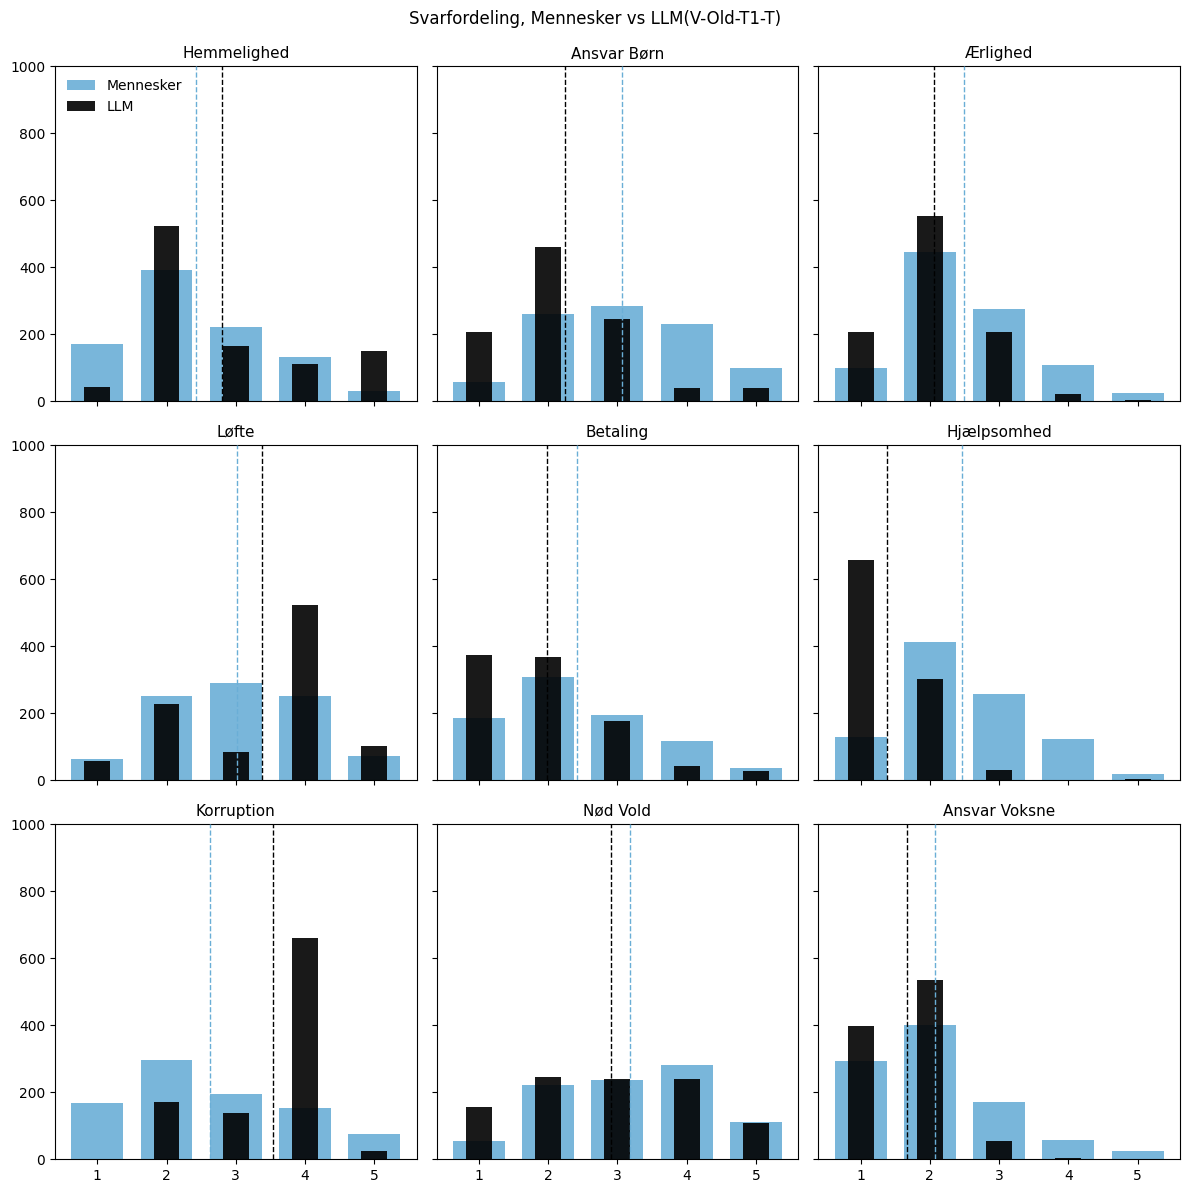

In [ ]:
HUMAN_COLOR = mpl.cm.Blues(0.5)
LLM_COLOR   = "black"

items = [
    "hemmelighed", "ansvar_børn", "ærlighed", "løfte",
    "betaling",    "hjælpsomhed", "korruption",
    "nød_vold",    "ansvar_voksne"
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

for idx, q in enumerate(items):
    r, c   = divmod(idx, 3)
    ax     = axes[r, c]

    h_freq = eval_df[f"{q}_ord"].value_counts().sort_index()
    l_freq = eval_df[f"{q}_pred"].value_counts().sort_index()

    x          = np.arange(1, 6)
    human_w    = 0.75
    llm_w      = human_w*0.50

    ax.bar(x, h_freq.reindex(x, fill_value=0),
           width=human_w, color=HUMAN_COLOR, alpha=0.9,
           label="Mennesker" if idx==0 else None, zorder=1)

    ax.bar(x, l_freq.reindex(x, fill_value=0),
           width=llm_w,   color=LLM_COLOR,   alpha=0.9,
           label="LLM" if idx==0 else None,  zorder=2)

    ax.axvline(eval_df[f"{q}_ord"].mean(),
               color=HUMAN_COLOR, ls="--", lw=1, zorder=3)
    ax.axvline(eval_df[f"{q}_pred"].mean(),
               color=LLM_COLOR,   ls="--", lw=1, zorder=3)

    ax.set_title(q.replace("_", " ").title(), fontsize=11)
    ax.set_xticks(x)
    ax.set_ylim(0, max(h_freq.max(), l_freq.max())*1.15)

axes[0, 0].set_ylim(0, 1000)

axes[0, 0].legend(frameon=False, loc="upper left")
fig.suptitle("Svarfordeling, Mennesker vs LLM(V-Old-T1-T)", y=0.99)
plt.tight_layout()

Making Aggregate Plot

In [ ]:
def plot_aggregate(overall_tbl):
    row        = overall_tbl.iloc[0]
    y          = 0
    height     = 1.15

    fig, ax = plt.subplots(figsize=(7, height))

    ax.hlines(y,
              row["mean_true"] - np.sqrt(row["var_true"]),
              row["mean_true"] + np.sqrt(row["var_true"]),
              linewidth=6, color=HUMAN_COLOR, alpha=.3,
              label="Mennesker (±1 SD)")
    ax.hlines(y,
              row["mean_pred"] - np.sqrt(row["var_pred"]),
              row["mean_pred"] + np.sqrt(row["var_pred"]),
              linewidth=2, color="black",
              label="LLM (±1 SD)")

    ax.plot(row["mean_true"], y, ">",  markersize=6, color=HUMAN_COLOR,
            label="Menneske-median")
    ax.plot(row["mean_pred"], y, "o",  markersize=6, color="black",
            label="LLM-median")

    ax.set_yticks([y])
    ax.set_yticklabels(["Total"])
    ax.set_xlabel("Tillidsindeks (1–5)")
    ax.set_xlim(0.9, 5.1)
    ax.xaxis.set_major_locator(mticker.FixedLocator([1, 2, 3, 4, 5]))
    ax.xaxis.set_minor_locator(mticker.NullLocator())
    ax.set_title("Aggregat, Mennesker vs LLM(V-Old-T1-T)")
    ax.grid(axis="x", alpha=0.3, linestyle=":")

    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.8),
              fancybox=True, shadow=False, ncol=2)
    fig.subplots_adjust(left=0.28, bottom=0.45)
    ax.set_ylim(-0.5, 0.5)

    x_text = ax.get_xlim()[1] - 0.05
    ax.text(x_text, y,
            f"{int(row['n']):,}",
            va="center", ha="left", fontsize=9, clip_on=False,
            bbox=dict(boxstyle="square", facecolor="white",
                      edgecolor="black", linewidth=0.5, alpha=1))

    plt.show()

# plot_aggregate(overall_tbl)

Making group-wise Plots

In [ ]:
def plot_gender(summary_df):
    summary_df = summary_df.sort_values("mean_true")
    summary_df["gender"] = summary_df["gender"].apply(lambda x: "\n".join(textwrap.wrap(str(x), width=30)))
    y = np.arange(len(summary_df))
    height = 1.2 + len(summary_df) * 0.5

    fig, ax = plt.subplots(figsize=(7, height))

    ax.hlines(y,
              summary_df["mean_true"] - np.sqrt(summary_df["var_true"]),
              summary_df["mean_true"] + np.sqrt(summary_df["var_true"]),
              linewidth=6, alpha=0.3, label="Mennesker (±1 SD)")
    ax.hlines(y,
              summary_df["mean_pred"] - np.sqrt(summary_df["var_pred"]),
              summary_df["mean_pred"] + np.sqrt(summary_df["var_pred"]),
              linewidth=2, color="black", label="LLM (±1 SD)")
    ax.plot(summary_df["mean_true"], y, ">", markersize=6, label="Menneske-median")
    ax.plot(summary_df["mean_pred"], y, "o", markersize=6, color="black", label="LLM-median")

    ax.set_yticks(y)
    ax.set_yticklabels(summary_df["gender"])
    ax.set_xlabel("Tillidsindeks (1–5)")
    ax.set_xlim(0.9, 5.1)
    ax.xaxis.set_major_locator(mticker.FixedLocator([1, 2, 3, 4, 5]))
    ax.xaxis.set_minor_locator(mticker.NullLocator())
    ax.set_title("Køn, Mennesker vs LLM(V-Old-T1-T)")
    ax.grid(axis="x", alpha=0.3, linestyle=":")

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.53), fancybox=True, shadow=False, ncol=2)
    fig.subplots_adjust(left=0.28, bottom=0.55)
    ax.set_ylim(-0.5, len(summary_df) - 0.5)

    x_text = ax.get_xlim()[1] - 0.05
    for yy, n in zip(y, summary_df["n"]):
        ax.text(
            x_text,
            yy,
            f"{int(n):,}",
            va="center",
            ha="left",
            fontsize=9,
            clip_on=False,
            bbox=dict(
                boxstyle="square",
                facecolor="white",
                edgecolor="black",
                linewidth=0.5,
                alpha=1,
            ),
        )

    plt.show()

#plot_gender(by_gender)

In [ ]:
def plot_age(summary_df):
    age_order = ["18–29", "30–44", "45–59", "60+"]
    summary_df["age_band"] = pd.Categorical(summary_df["age_band"], categories=age_order, ordered=True)
    summary_df = summary_df.sort_values("age_band")
    summary_df["age_band"] = summary_df["age_band"].apply(lambda x: "\n".join(textwrap.wrap(str(x), width=30)))
    y = np.arange(len(summary_df))
    height = 1.2 + len(summary_df) * 0.5

    fig, ax = plt.subplots(figsize=(7, height))

    ax.hlines(y,
              summary_df["mean_true"] - np.sqrt(summary_df["var_true"]),
              summary_df["mean_true"] + np.sqrt(summary_df["var_true"]),
              linewidth=6, alpha=0.3, label="Mennesker (±1 SD)")
    ax.hlines(y,
              summary_df["mean_pred"] - np.sqrt(summary_df["var_pred"]),
              summary_df["mean_pred"] + np.sqrt(summary_df["var_pred"]),
              linewidth=2, color="black", label="LLM (±1 SD)")
    ax.plot(summary_df["mean_true"], y, ">", markersize=6, label="Menneske-median")
    ax.plot(summary_df["mean_pred"], y, "o", markersize=6, color="black", label="LLM-median")

    ax.set_yticks(y)
    ax.set_yticklabels(summary_df["age_band"])
    ax.set_xlabel("Tillidsindeks (1–5)")
    ax.set_xlim(0.9, 5.1)
    ax.xaxis.set_major_locator(mticker.FixedLocator([1, 2, 3, 4, 5]))
    ax.xaxis.set_minor_locator(mticker.NullLocator())
    ax.set_title("Aldersgrupper, Mennesker vs LLM(V-Old-T1-T)")
    ax.grid(axis="x", alpha=0.3, linestyle=":")

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.32), fancybox=True, shadow=False, ncol=2)
    fig.subplots_adjust(left=0.28, bottom=0.5)
    ax.set_ylim(-0.5, len(summary_df) - 0.5)

    x_text = ax.get_xlim()[1] - 0.05
    for yy, n in zip(y, summary_df["n"]):
        ax.text(
            x_text,
            yy,
            f"{int(n):,}",
            va="center",
            ha="left",
            fontsize=9,
            clip_on=False,
            bbox=dict(
                boxstyle="square",
                facecolor="white",
                edgecolor="black",
                linewidth=0.5,
                alpha=1,
            ),
        )

    plt.show()

#plot_age(by_ageband)

In [ ]:
def plot_education(summary_df):
    edu_order = [
        "Grund-/folkeskole",
        "Almen gymnasial uddannelse (studentereksamen/HF)",
        "Erhvervsgymnasial uddannelse (HH/HTX/HHX)",
        "Erhvervsfaglig uddannelse",
        "Kort videregående uddannelse under 3 år",
        "Mellemlang videregående uddannelse 3-4 år",
        "Lang videregående uddannelse 5 år eller mere",
        "Forskeruddannelse (f.eks. ph.d.)"
    ]
    summary_df["education"] = pd.Categorical(summary_df["education"], categories=edu_order, ordered=True)
    summary_df = summary_df.sort_values("education")
    summary_df["education"] = summary_df["education"].apply(lambda x: "\n".join(textwrap.wrap(str(x), width=25)))
    y = np.arange(len(summary_df))
    height = 1.2 + len(summary_df) * 0.5

    fig, ax = plt.subplots(figsize=(7.5, height))

    ax.hlines(y,
              summary_df["mean_true"] - np.sqrt(summary_df["var_true"]),
              summary_df["mean_true"] + np.sqrt(summary_df["var_true"]),
              linewidth=6, alpha=0.3, label="Mennesker (±1 SD)")
    ax.hlines(y,
              summary_df["mean_pred"] - np.sqrt(summary_df["var_pred"]),
              summary_df["mean_pred"] + np.sqrt(summary_df["var_pred"]),
              linewidth=2, color="black", label="LLM (±1 SD)")
    ax.plot(summary_df["mean_true"], y, ">", markersize=6, label="Menneske-median")
    ax.plot(summary_df["mean_pred"], y, "o", markersize=6, color="black", label="LLM-median")

    ax.set_yticks(y)
    ax.set_yticklabels(summary_df["education"], fontsize=8)
    ax.set_xlabel("Tillidsindeks (1–5)")
    ax.set_xlim(0.9, 5.1)
    ax.xaxis.set_major_locator(mticker.FixedLocator([1, 2, 3, 4, 5]))
    ax.xaxis.set_minor_locator(mticker.NullLocator())
    ax.set_title("Uddannelse, Mennesker vs LLM(V-Old-T1-T)")
    ax.grid(axis="x", alpha=0.3, linestyle=":")

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14), fancybox=True, shadow=False, ncol=2)
    fig.subplots_adjust(left=0.28, bottom=0.28)
    ax.set_ylim(-0.5, len(summary_df) - 0.5)

    x_text = ax.get_xlim()[1] - 0.05
    for yy, n in zip(y, summary_df["n"]):
        ax.text(
            x_text,
            yy,
            f"{int(n):,}",
            va="center",
            ha="left",
            fontsize=9,
            clip_on=False,
            bbox=dict(
                boxstyle="square",
                facecolor="white",
                edgecolor="black",
                linewidth=0.5,
                alpha=1,
            ),
        )

    plt.show()

#plot_education(by_education)

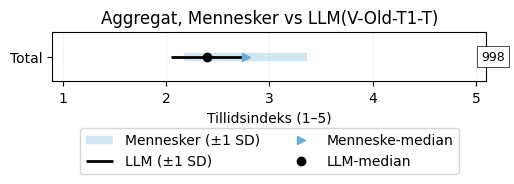

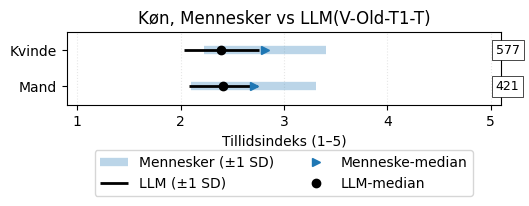

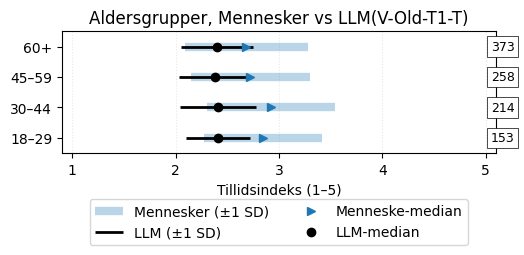

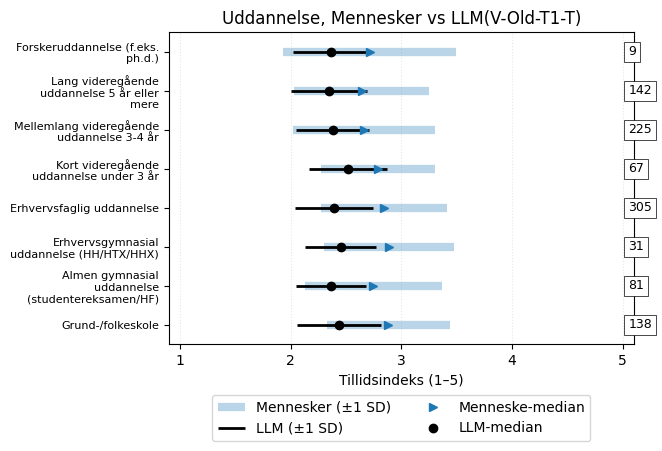

In [ ]:
plot_aggregate(overall_tbl)
plot_gender(by_gender)
plot_age(by_ageband)
plot_education(by_education)